In [1]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, plot_predict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pmdarima.arima.utils import ndiffs
from statsmodels.tsa.arima.model import ARIMA

from datetime import datetime, date

KeyboardInterrupt: 

In [3]:
df = pd.read_csv('../data/btcusd-history-price-daily.csv', delimiter=';', parse_dates=['time_period_end'], usecols=['rate_close', 'time_period_end'])
# df = df[pd.DatetimeIndex(df['time_period_end']).year==2016]
# df = df[pd.DatetimeIndex(df['time_period_end']).month==1]
# df = df[pd.DatetimeIndex(df['time_period_end']).day<2]
df

,time_period_end,rate_close
0,2016-01-01 01:00:00+00:00,430.831630
1,2016-01-01 02:00:00+00:00,430.378803
2,2016-01-01 03:00:00+00:00,430.608821
3,2016-01-01 04:00:00+00:00,432.903554
4,2016-01-01 05:00:00+00:00,435.595708
...,...,...
59156,2022-09-30 21:00:00+00:00,19423.937453
59157,2022-09-30 22:00:00+00:00,19365.750304
59158,2022-09-30 23:00:00+00:00,19374.139589
59159,2022-10-01 00:00:00+00:00,19421.220257


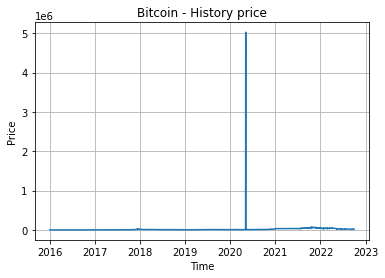

<Figure size 2160x720 with 0 Axes>

In [4]:
plt.title('Bitcoin - History price')
plt.plot(df['time_period_end'], df['rate_close'])
plt.xlabel('Time')
plt.grid(True)
plt.ylabel('Price')
plt.figure(figsize=(30, 10))
#display(plt.plot(df['time_period_end'], df['rate_close']))
plt.show()

# Encontrado los ceficientes d, m, q

## Orden de diferenciacion (d)

In [6]:
series = df.loc[:, 'rate_close'].values

result = adfuller(series, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'n_lags: {result[1]}')
print(f'p-value: {result[1]}')


ADF Statistic: -1.2563529729740441
n_lags: 0.6488969792940908
p-value: 0.6488969792940908


**El p-value es mayor al nivel de significacia (0.05) por lo que hay que ajustar la serie para que puede ser estacionaria.**

KeyboardInterrupt: 

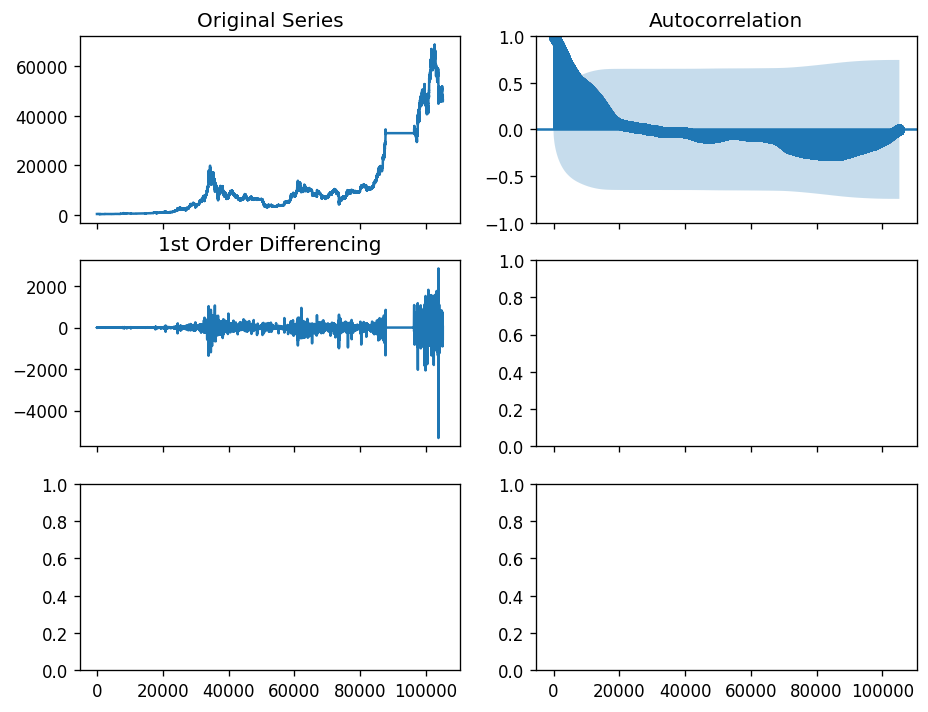

In [8]:
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

fig, axes = plt.subplots(3, 2, sharex=True)

# Original Series
axes[0, 0].plot(df.rate_close)
axes[0, 0].set_title('Original Series')
plot_acf(df.rate_close, ax=axes[0, 1], lags=(len(df)-1))

# # 1st Differencing
axes[1, 0].plot(df.rate_close.diff())
axes[1, 0].set_title('1st Order Differencing')
plot_acf(df.rate_close.diff().dropna(), ax=axes[1, 1], lags=(len(df)-2))

# # 2nd Differencing
axes[2, 0].plot(df.rate_close.diff().diff())
axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df.rate_close.diff().diff().dropna(), ax=axes[2, 1], lags=(len(df)-3))

plt.show()

**Se puede ver que la serie con orden de diferenciacion 1 tiene un comportamiento bastante estacionario.**

In [7]:
## Adf Test
adf = ndiffs(df['rate_close'], test='adf')  # 1
adf

# KPSS test
kpss = ndiffs(df['rate_close'], test='kpss')  # 1
kpss

# PP test:
pp = ndiffs(df['rate_close'], test='pp')  # 1
pp

1

**Al utilizar ndiffs podemos comprobar que el nivel de significacion necesario para convertir la serie en estacionaria es 1.**

---

## Orden de AR (p)

**El coeficiente q se puede determinar por medio de PACF, que es la Autocorrelacion Parcial.**

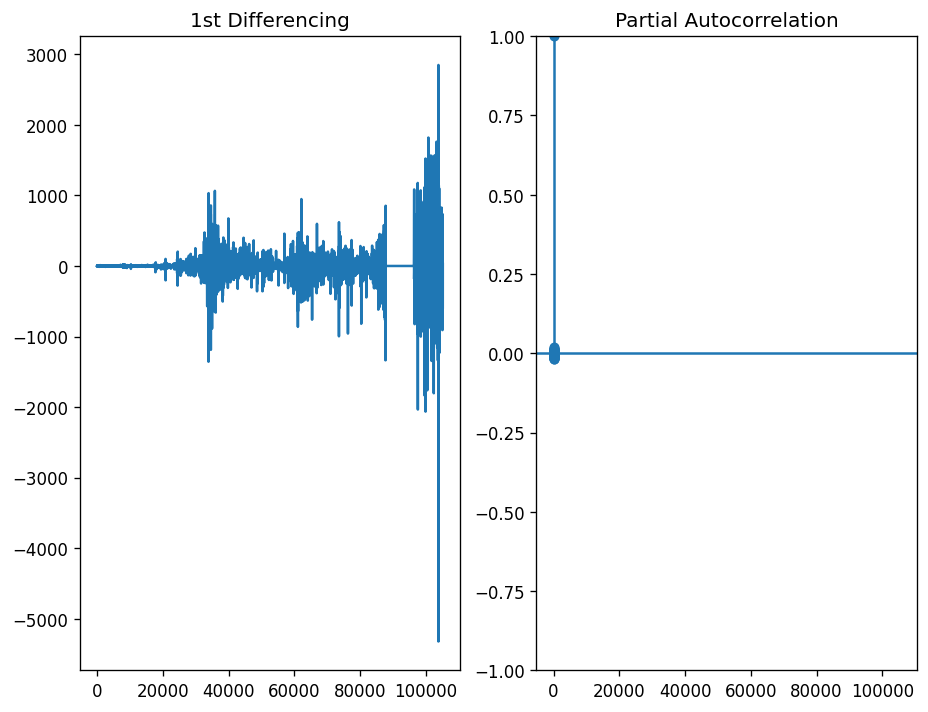

In [13]:
# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(9, 7), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df['rate_close'].diff())
axes[0].set_title('1st Differencing')
#plot_pacf(df['rate_close'].diff().dropna(), ax=axes[1], method='ywm', lags=(len(df)*0.5)-2)
plot_pacf(df['rate_close'].diff().dropna(), ax=axes[1], method='ywm')

plt.show()

**Se puede ver que el coeficiente 1 es significante.**

---

## Orden de MA (q)

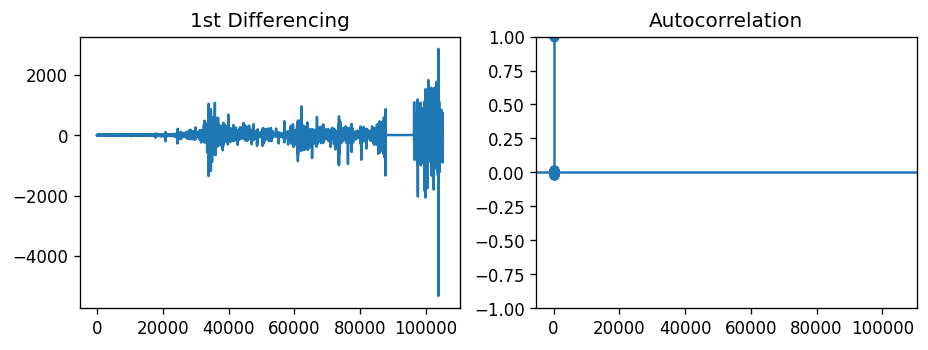

In [14]:
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df['rate_close'].diff())
axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(df['rate_close'].diff().dropna(), ax=axes[1])

plt.show()

**Se puede ver que el coeficiente q es de 1.**

---

## ARIMA

**Ahora que se conocen los 3 coeficientes se puede crear el modelo bajo las siguientes condiciones:**
- **d:** 1
- **p:** 1
- **q:** 1

In [10]:
df.index = pd.date_range(start='2016-01-01 00:30:00', end='2022-10-02 00:00:00', freq='1day')
model = ARIMA(df['rate_close'], order=(1,1,1))
model_fit = model.fit()
print(model_fit.summary())

ValueError: Invalid frequency: 1day

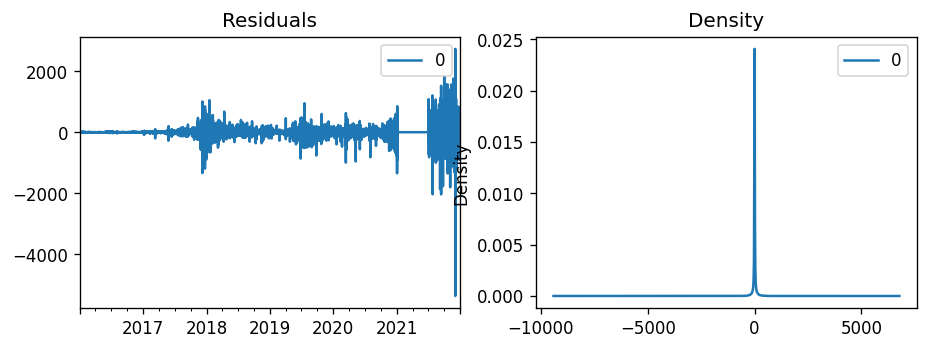

In [16]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals = residuals[1:]
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

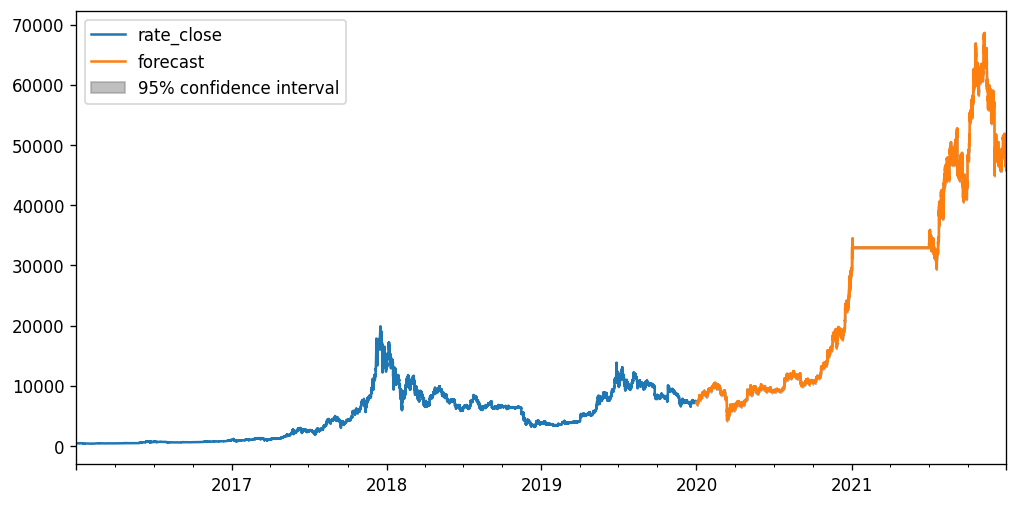

In [17]:
plt.rcParams.update({'figure.figsize':(10,5), 'figure.dpi':120})

# # Actual vs Fitted
fig, ax = plt.subplots()
ax = df['rate_close'].loc[:'2020-01-01 00:00:00'].plot(ax=ax)
plot_predict(model_fit, start='2020-01-01 00:00:00', ax=ax, dynamic=False, plot_insample=False, alphafloat=0)
plt.show()

# model_fit.prepare_data()

# Armando modelo predictivo

In [12]:
df.index = pd.date_range(start='2016-01-01 00:30:00', end='2022-10-02 00:00:00', freq='D')
df

,time_period_end,rate_close
2016-01-01 00:30:00,2016-01-02 00:00:00+00:00,435.307783
2016-01-02 00:30:00,2016-01-03 00:00:00+00:00,434.463018
2016-01-03 00:30:00,2016-01-04 00:00:00+00:00,431.336318
2016-01-04 00:30:00,2016-01-05 00:00:00+00:00,434.022204
2016-01-05 00:30:00,2016-01-06 00:00:00+00:00,432.644679
...,...,...
2022-09-27 00:30:00,2022-09-28 00:00:00+00:00,19108.877072
2022-09-28 00:30:00,2022-09-29 00:00:00+00:00,19410.072627
2022-09-29 00:30:00,2022-09-30 00:00:00+00:00,19596.532199
2022-09-30 00:30:00,2022-10-01 00:00:00+00:00,19421.220257


1236503.197 -> 1 1 1
1236505.256 -> 1 1 2
1236533.667 -> 1 2 2
1236506.456 -> 2 2 2
1236499.188 -> 3 2 2 --> SI/SI  41385.005
1237326.714 -> 3 3 2
               4 1 1 -->        41387.201
1236496.251 -> 4 2 2 --> SI/NO  41380.703
1239245.559 -> 4 3 3

In [18]:
#model = ARIMA(train['rate_close'], order=(1, 1, 1))
#model = ARIMA(train['rate_close'], order=(2, 2, 2))
model = ARIMA(df['rate_close'], order=(4, 2, 2))
fitted = model.fit()  

fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             rate_close   No. Observations:                 2466
Model:                 ARIMA(4, 2, 2)   Log Likelihood              -20683.351
Date:                Sun, 23 Oct 2022   AIC                          41380.703
Time:                        03:51:14   BIC                          41421.369
Sample:                    01-01-2016   HQIC                         41395.477
                         - 10-01-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.3814      0.031    -44.307      0.000      -1.443      -1.320
ar.L2         -0.5328      0.013    -40.232      0.000      -0.559      -0.507
ar.L3         -0.2021      0.013    -15.462      0.000      -0.228      -0.176
ar.L4         -0.0518      0.010     -5.235      0.000      -0.071      -0.032
ma.L1         -0.0013      0.031     -0.043      0.966      -0.061       0.059
ma.L2         -0.9987      0.032    -31.604      0.000      -1.061      -0.937
sigma2      1.142e+06   3.76e-09   3.04e+14      0.000    1.14e+06    1.14e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):          17792840.38
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               9.43   Skew:                             8.85
Prob(H) (two-sided):                  0.00   Kurtosis:                       418.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.03e+28. Standard errors may be unstable.
"""

In [102]:
plt.rcParams.update({'figure.figsize':(10,5), 'figure.dpi':120})

# Forecast
conf = fitted.get_forecast(len(test), alpha=0.05)  # 95% conf
fc = fitted.forecast(len(test), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf.conf_int()['lower rate_close'], index=test.index)
upper_series = pd.Series(conf.conf_int()['upper rate_close'], index=test.index)

fc
# conf

# Plot
# plt.figure(figsize=(12,5), dpi=100)
# plt.plot(train['rate_close'], label='training')
# plt.plot(test['rate_close'], label='actual')
# plt.plot(train[:10]['rate_close'], label='forecast')
# plt.fill_between(lower_series.index, lower_series, upper_series, 
#                  color='k', alpha=.15)
# plt.title('Forecast vs Actuals')
# plt.legend(loc='upper left', fontsize=8)

2022-01-01 00:30:00    46188.109950
2022-01-01 01:00:00    46188.687815
2022-01-01 01:30:00    46190.347590
2022-01-01 02:00:00    46189.508897
2022-01-01 02:30:00    46191.207409
                           ...     
2022-04-19 14:00:00    48465.511012
2022-04-19 14:30:00    48465.947911
2022-04-19 15:00:00    48466.384810
2022-04-19 15:30:00    48466.821709
2022-04-19 16:00:00    48467.258608
Freq: 30T, Name: predicted_mean, Length: 5216, dtype: float64

In [109]:
df
initial_date = datetime.fromisoformat('2022-01-01T00:30:00').timestamp()

date.fromtimestamp(initial_date)

fc = fitted.forecast(25, alpha=0.05)  #95% conf
# for i in range(len(lista)):
#     print(i)

2022-01-01 00:30:00    46188.109950
2022-01-01 01:00:00    46188.687815
2022-01-01 01:30:00    46190.347590
2022-01-01 02:00:00    46189.508897
2022-01-01 02:30:00    46191.207409
2022-01-01 03:00:00    46190.389276
2022-01-01 03:30:00    46192.075228
2022-01-01 04:00:00    46191.269062
2022-01-01 04:30:00    46192.943062
2022-01-01 05:00:00    46192.148794
2022-01-01 05:30:00    46193.810954
2022-01-01 06:00:00    46193.028470
2022-01-01 06:30:00    46194.678902
2022-01-01 07:00:00    46193.908090
2022-01-01 07:30:00    46195.546906
2022-01-01 08:00:00    46194.787653
2022-01-01 08:30:00    46196.414966
2022-01-01 09:00:00    46195.667162
2022-01-01 09:30:00    46197.283080
2022-01-01 10:00:00    46196.546616
2022-01-01 10:30:00    46198.151249
2022-01-01 11:00:00    46197.426016
2022-01-01 11:30:00    46199.019472
2022-01-01 12:00:00    46198.305362
2022-01-01 12:30:00    46199.887748
Freq: 30T, Name: predicted_mean, dtype: float64

In [126]:

data_model = df['rate_close']

other = pd.DataFrame([12], columns=list('rate_close'), index=pd.date_range(start='2016-01-01 00:30:00', end='2022-01-01 00:00:00', freq='30min'))
other

# for i in range(2):
#     model = ARIMA(df['rate_close'], order=(3, 2, 2))
#     fitted = model.fit()

ValueError: Shape of passed values is (1, 1), indices imply (1, 10)